In [7]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px

class KohonenNet:
    def __init__(self, n_inputs, N, M, neigh_fun='gauss', neigh_scale=1, quench_param=1, grid_shape='rect'):
        if neigh_scale<0.1 or neigh_scale>1: 
            raise AttributeError(f'neigh_scale should be in range [0.1, 1]. Received "{neigh_scale}".')
        if N<1 or M<1:
            raise AttributeError("Both N and M should be positive integers.")
        if neigh_fun not in ['gauss', 'hat']:
            raise AttributeError(f'neigh_fun should be one of "gauss" or "hat". "{neigh_fun}" is incorrect.')
        self.n_inputs = n_inputs
        self.N = N
        self.M = M
        if neigh_fun == 'gauss':
            self.neigh_fun = lambda x: np.exp(-(x*neigh_scale)**2)
        elif neigh_fun == 'hat':
            self.neigh_fun = lambda x: (2-4*(x*neigh_scale)**2)*np.exp(-(x*neigh_scale)**2)
        self.quench = lambda x: np.exp(-x/quench_param)
        self.grid_shape = grid_shape
        if grid_shape == 'rect':
            self.neurons_pos_x = np.repeat(np.arange(N), M)
            self.neurons_pos_y = np.tile(np.arange(M), N)
            self.neuron_radius = 0.5 #only for plotting
        elif grid_shape == 'hexagon':
            #self.neurons_pos_x = np.repeat(np.arange(N), M)
            #self.neurons_pos_y = np.tile(np.concatenate((np.arange(0, M*2/np.sqrt(3), 2/np.sqrt(3)), np.arange(1/np.sqrt(3), M*2/np.sqrt(3)+1/np.sqrt(3), 2/np.sqrt(3)))), int(N/2))
            #self.neuron_radius = 1/np.sqrt(3)
            #if N % 2 != 0: self.neurons_pos_y = np.append(self.neurons_pos_y, np.arange(0, M*2/np.sqrt(3), 2/np.sqrt(3)))
            raise NotImplementedError("Not Implemented ('yet').")
        else: raise AttributeError(f"Only 'rect' and 'hexagon' grid shapes are allowed. '{grid_shape}' given.")
        self.neurons_weights = np.random.normal(size=(M*N, n_inputs)) # the neurons' weights will be stored in an array of that shape.
        
    def train(self, epochs, data):
        for t in range(1, epochs+1):
            perm_data = np.random.permutation(data)
            cur_quench = self.quench(t)
            for x in perm_data:
                x_w_diff = np.subtract(x, self.neurons_weights)
                #assert (x_w_diff[0] == x - self.neurons_weights[0]).all() #checked
                min_id = np.argmin(np.linalg.norm(x_w_diff, axis=1))
                x_min = self.neurons_pos_x[min_id]
                y_min = self.neurons_pos_y[min_id]
                cur_dist_vec = np.sqrt((self.neurons_pos_x-x_min)**2+(self.neurons_pos_y-y_min)**2) # faster than built-in fun in this case
                #assert cur_dist_vec[0] == np.linalg.norm(np.array([self.neurons_pos_x[0], self.neurons_pos_y[0]]) - np.array([x_min, y_min])) #checked
                self.neurons_weights += x_w_diff * self.neigh_fun(cur_dist_vec)[:, np.newaxis] * cur_quench # multiply every column of matrix by a vector element-wise
                #9 times faster than iterative attitude
                #for i in range(self.M*self.N):
                    #cur_dist = vect_euclidean(np.array([self.neurons_pos_x[i], self.neurons_pos_y[i]]), np.array([x_min, y_min]))
                    #assert cur_dist == cur_dist_vec[i]
                    #assert (np.abs(tmp1[i] - self.neigh_fun(cur_dist) * cur_quench * x_w_diff[i,:])<1e-8).all()
                    #self.neurons_weights[i,:] += self.neigh_fun(cur_dist) * cur_quench * x_w_diff[i,:] #funkcja sasiedztwa - czy przekazujemy tam numer epoki oraz wsp skalujacy?
            
    def predict(self, data):
        labels = np.empty(len(data,), dtype = 'int')
        for i in range(len(data)):
            x_w_diff = np.subtract(data[i,:], self.neurons_weights)
            min_id = np.argmin(np.linalg.norm(x_w_diff, axis=1))
            labels[i] = min_id
        return labels

In [68]:
def plot_neurons(data, orig_lab, pred_lab, kohonen_net):
    exper = pd.concat([pd.DataFrame(data[:,:-1]), pd.Series(orig_lab, name='orig_label'), pd.Series(pred_lab, name = 'label')], axis = 1)
    def take_most_frequent_class_or_none(x):
        z = x.value_counts().index[0]
        return z
    list_of_lacking_neurons = [i for i in range(kohonen_net.N*kohonen_net.M) if not exper.label.isin([i]).any()]
    most_freq_labels = exper.iloc[:,-2:].groupby(by='label').agg(take_most_frequent_class_or_none).iloc[:,-1]
    div = []
    for i in range(max(most_freq_labels)+1):
        div.append(most_freq_labels.index[np.where(most_freq_labels == i)[0]].tolist())
    fig, ax = plt.subplots(figsize = (10, 10*kohonen_net.M/kohonen_net.N))
    x = np.random.uniform(-0.5, 0.5, len(pred_lab))
    y = np.random.uniform(-1, 1, len(pred_lab)) * np.sqrt(kohonen_net.neuron_radius**2-x**2)
    x += (kohonen_net.neurons_pos_x[pred_lab])
    y += (kohonen_net.neurons_pos_y[pred_lab])
    sc = ax.scatter(x, y, c = orig_lab, s = 50)
    for i in range(kohonen_net.M * kohonen_net.N):
        try:
            cur_edgecolor = sc.to_rgba(most_freq_labels[i])
            alpha = 1
        except:
            cur_edgecolor = 'black'
            alpha = 0.3
        ax.add_patch(plt.Circle((kohonen_net.neurons_pos_x[i], kohonen_net.neurons_pos_y[i]),
                                kohonen_net.neuron_radius, edgecolor = cur_edgecolor, fill = False, linewidth = 4, alpha=alpha))
    plt.xlim([-0.75, kohonen_net.N-0.25])
    if kohonen_net.grid_shape == 'rect':
        plt.ylim([-0.75, kohonen_net.M-0.25])
    else:
        plt.ylim([-0.75, (kohonen_net.M*2+0.5)/np.sqrt(3)])
    plt.title('The closest neurons and observations of particular class after training the Kohonen Net.')
    plt.axis('off')
    plt.show()
    return [neurons_clusters(i, div) for i in lab] #return new labels based on clustered neurons
def neurons_clusters(x, division_list):
    for i, elems in enumerate(division_list):
        if x in elems:
            return i

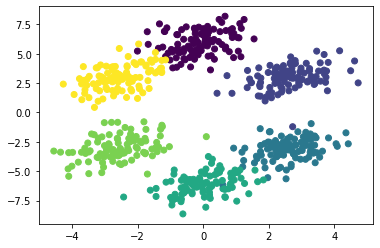

In [354]:
data = pd.read_csv("../dane/hexagon.csv").to_numpy()
data_train = data[:,0:2]
plt.scatter(data[:,0], data[:,1], c = data[:,2])
plt.show()

In [362]:
k = KohonenNet(2, 4, 3, grid_shape = 'rect')
k.train(50, data_train)

In [363]:
lab = k.predict(data_train).astype(int)

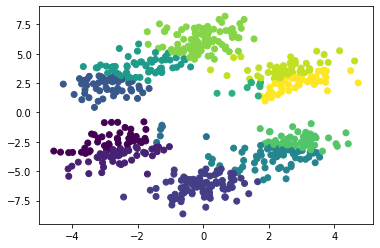

In [364]:
plt.scatter(data[:,0], data[:,1], c = lab)
plt.show()

Dużo klastrów, 12 - w zależności od neuronów, do których wpadły obserwacji

In [366]:
len(np.unique(lab))

12

Uwzględnione etykiety, nie tyle do uczenia co do pogrupowania neuronów

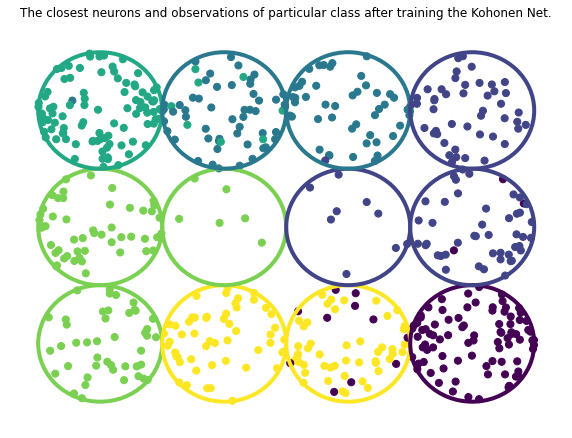

In [367]:
new_labels_division = plot_neurons(data, data[:,2].astype(int), lab, k)

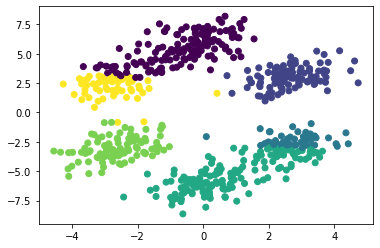

In [368]:
plt.scatter(data[:,0], data[:,1], c = new_labels_division)
plt.show()

Pytanie:

Po przyswojeniu tematu sieci Kohonena w praktyce, doszedłem do wniosku, że na slajdach wykładowych z funkcjami sąsiedztwa, na których się wzorowaliśmy, panuje chaos. Funkcja sąsiedztwa powinna de facto przyjmować trzy argumenty: x - odległość między neuronem a prezentowanym wzorcem, t - obecny czas, czyli numer iteracji oraz ewentualnie r - pewien współczynnik skali, inaczej interpretowany w zależności od funkcji (w funkcji Koło oznacza maksymalną odległość neuronów, których wagi modyfikujemy, w Gaussie wymnażamy x przez r, przez co zmienamy odległość sąsiedztwa, w Kapeluszu wydaje mi się że podobnie). Na drugim z analizowanych slajdów (nr 55) jest dodane jak uwzględnić również czas w dwóch pierwszych funkcjach, nie ma jednak informacji jak dodać czas do Kapelusza. Jeśli ma być to nadal minus druga pochodna funkcji gaussowskiej, to powinno to być $(2-4(x*t)^2)*t^2*exp(-(x*t)^2)$, pamiętając nadal o tym że argument x jest 'w pamięci' mnożony przez r (x*=r przed wykonaniem funkcji). Czy to dobre rozumowanie?

Druga sprawa:
W jaki sposób przyporządkowywać wzorcom konkretne klasy na podstawie efektów klastrowania? Czy klasą ma być neuron, do którego dany wzorzec jest najbardziej podobny? Takie rozwiązanie powoduje, że klas będzie sporo, często niemal tyle co neuronów. Dostrzegam dwa możliwe podejścia: pierwsze, które na podstawie etykiet w danych określa najczęściej występującą klasę w wzorcach dla których dany neuron jest najbliższym. Takie rozwiązanie byłoby skuteczne, ale nie wiem czy pożądane ze względu na dostęp do etykiet (wprawdzie nie w czasie trenowania, tylko po fakcie, ale jednak) oraz z góry narzuconą liczbę klas. Drugie, wydaje mi się że określone na wykładzie, polegałoby na połączeniu neuronów na podstawie podobieństwa ich wag. Tutaj określenie jednak podobieństwa może być bardzo subiektywne, trudno mi sobie wyobrazić automatyzację tej operacji. Alternatywą znalezioną w podlinkowanym do wykładu materiale może być łączenie  https://clarkdatalabs.github.io/soms/SOM_NBA#mapping_distance, jednak mnie nadal nie przekonuje (wartość na jednym neuronie to suma odległości do każdego z 6 sąsiadów? Jak wtedy rozróżnić która para jest blisko siebie?). Jakie podejście jest oczekiwane?

In [67]:
cube = pd.read_csv("../dane/cube.csv")
train_data_cube = pd.read_csv("../dane/cube.csv").to_numpy()[:,0:3]
cube_labels = pd.read_csv("../dane/cube.csv").to_numpy()[:,3].astype(int)
cube['c'] = cube['c'].astype('str')
fig = px.scatter_3d(cube, x='x', y='y', z='z',
              color='c')
fig.update_traces(mode='markers', marker_size=2.5)
fig.show()

In [52]:
k = KohonenNet(3, 6, 6, grid_shape = 'rect')
k.train(500, train_data_cube)

In [53]:
lab = k.predict(train_data_cube).astype(int)

In [54]:
fig = px.scatter_3d(cube, x='x', y='y', z='z',
              color=lab.astype('str'))
fig.update_traces(mode='markers', marker_size=2.5)
fig.show()

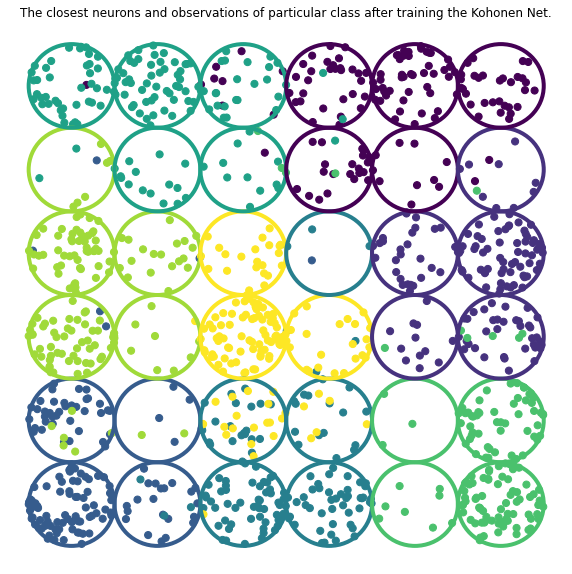

In [69]:
new_labels_division_2 = plot_neurons(train_data_cube, cube_labels, lab, kohonen_net=k)

In [74]:
fig = px.scatter_3d(cube, x='x', y='y', z='z',
              color=np.array(new_labels_division_2).astype('str'))
fig.update_traces(mode='markers', marker_size=2.5)
fig.show()